In [28]:
import random
import tensorflow as tf

options = 4

# The following methods are used for randomized data generation

def generateKey(q):
    key = []
    for i in range(q):
        key.append(random.randint(1, options))
    return key

normal_accuracy = 0.80

def generateAns(key):
    answers = []
    for i in key:
        if (random.random() > normal_accuracy):
            answers.append(random.choice([n for n in range(1, options) if n != i]))
        else: 
            answers.append(i)
    return answers

# List contains a 1 or 0 depending on whether the key and ans list match
def generateAnsList(key, ans):
    ansL = []
    for i in range(len(key)):
        if (key[i] == ans[i]):
            ansL.append(1)
        else:
            ansL.append(0) 
    return ansL

def calcAcc(key, ans):
    ansL = generateAnsList(key, ans)
    return sum(ansL)/len(ansL)
    
def frameShift(ans, f):
    shiftedAns = ans.copy()
    a = 1
    while (a > f):
        shift = random.choice([n for n in range(-len(ans), len(ans)) if n != 0])
        if (shift < 0): 
            shift = -(shift + 1)
            shiftedAns.pop(shift)
            shiftedAns.append(random.randint(1, options))
        else: 
            shift = shift - 1
            shiftedAns.pop(-1)
            shiftedAns.insert(shift, random.randint(1, options))
        
        a = random.random()
        
    return shiftedAns

In [29]:
# Method that builds a neural network to predict if the input list has been shifted or not
# input_list must either contain 1 or 0s according to whether it matches the key

def detectFrameshift(input_list):
    q = len(input_list)
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(q,)),
        tf.keras.layers.Dense(q / 2, activation='relu'),
        tf.keras.layers.Dense(10, activation='relu'), 
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam',
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
    
    samples = q * 75
    shiftProb = 0.80


    ansInputs = []
    ansOutputs = []
    ansProbs = []

    for i in range(samples):
        key = generateKey(q)
        ansL = generateAnsList(key, generateAns(key))
        ansInputs.append(ansL)
        ansOutputs.append(0)
        ansProbs.append(calcAcc(key, ansL))
        ansL = generateAnsList(key, frameShift(generateAns(key), shiftProb))
        ansInputs.append(ansL)
        ansOutputs.append(1)
        ansProbs.append(calcAcc(key, ansL))   

    ansInputTrain = ansInputs[:int(samples*.8)]
    ansOutputTrain = ansOutputs[:int(samples*.8)]

    ansInputTest = ansInputs[int(samples*.8):]
    ansOutputTest = ansOutputs[int(samples*.8):]

    model.fit(ansInputTrain, ansOutputTrain, epochs=25)
    
    print(model.evaluate(ansInputTrain, ansOutputTrain))
    x = model.evaluate(ansInputTest, ansOutputTest)
    print(x)
    
    pred = model.predict([input_list])
    
    #print(pred)
    
    return x

In [3]:
# Method that builds a neural network to predict the initial accuracy of a frameshifted input list
# input_list must either contain 1 or 0s according to whether it matches the key list

def unshiftAccuracy(input_list):
    q = len(input_list)

    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(q,)),
        tf.keras.layers.Dense(q / 2, activation='relu'),
        tf.keras.layers.Dense(q / 2, activation='relu'),
        tf.keras.layers.Dense(q / 2, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='mae',
        metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])

    samples = q * 25
    shiftProb = 0.80


    ansInputs = []
    ansOutputs = []
    ansProbs = []

    for n in range(samples):
        for i in range(int(100/options),95,5):
            normal_accuracy = i/100
            key = generateKey(q)
            ansL = generateAnsList(key, frameShift(generateAns(key), shiftProb))
            ansInputs.append(ansL)
            ansOutputs.append(normal_accuracy)
            ansProbs.append(calcAcc(key, ansL))

    samples = len(ansInputs)

    ansInputTrain = ansInputs[:int(samples*.8)]
    ansOutputTrain = ansOutputs[:int(samples*.8)]


    ansInputTest = ansInputs[int(samples*.8):]
    ansOutputTest = ansOutputs[int(samples*.8):]

    print(len(ansInputTest))

    model.fit(ansInputTrain, ansOutputTrain, epochs=25)

    print(model.evaluate(ansInputTrain, ansOutputTrain))
    x = model.evaluate(ansInputTest, ansOutputTest)
    print(x)
    
    pred = model.predict([input_list])

    print(pred)
    
    return x

In [4]:
test1 = [1, 1, 1, 1, 1, 1, 1, 
        1, 1, 0, 0, 0, 0, 0, 0, 1]

test2 = [1, 1, 1, 1, 1, 1, 
          1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 
          1, 0, 1, 0, 0, 1, 0, 0]

In [10]:
detectFrameshift(test1)

Epoch 1/25
30/30 [==============================] - 2s 12ms/step - loss: 0.6714 - accuracy: 0.5510
Epoch 2/25
30/30 [==============================] - 0s 5ms/step - loss: 0.6469 - accuracy: 0.6031
Epoch 3/25
30/30 [==============================] - 0s 9ms/step - loss: 0.6272 - accuracy: 0.6469
Epoch 4/25
30/30 [==============================] - 0s 10ms/step - loss: 0.6042 - accuracy: 0.6979
Epoch 5/25
30/30 [==============================] - 0s 10ms/step - loss: 0.5766 - accuracy: 0.7354
Epoch 6/25
30/30 [==============================] - 0s 3ms/step - loss: 0.5389 - accuracy: 0.7740
Epoch 7/25
30/30 [==============================] - 0s 6ms/step - loss: 0.4905 - accuracy: 0.8073
Epoch 8/25
30/30 [==============================] - 0s 3ms/step - loss: 0.4491 - accuracy: 0.8292
Epoch 9/25
30/30 [==============================] - 0s 6ms/step - loss: 0.4145 - accuracy: 0.8396
Epoch 10/25
30/30 [==============================] - 0s 6ms/step - loss: 0.3903 - accuracy: 0.8490
Epoch 11/25
30/3

array([[0.96375537]], dtype=float32)

In [5]:
detectFrameshift(test1)

Epoch 1/25
30/30 [==============================] - 1s 4ms/step - loss: 0.6716 - accuracy: 0.6000
Epoch 2/25
30/30 [==============================] - 0s 3ms/step - loss: 0.6393 - accuracy: 0.6771
Epoch 3/25
30/30 [==============================] - 0s 3ms/step - loss: 0.6101 - accuracy: 0.7198
Epoch 4/25
30/30 [==============================] - 0s 3ms/step - loss: 0.5771 - accuracy: 0.7521
Epoch 5/25
30/30 [==============================] - 0s 3ms/step - loss: 0.5459 - accuracy: 0.7729
Epoch 6/25
30/30 [==============================] - 0s 3ms/step - loss: 0.5153 - accuracy: 0.7927
Epoch 7/25
30/30 [==============================] - 0s 4ms/step - loss: 0.4873 - accuracy: 0.8094
Epoch 8/25
30/30 [==============================] - 0s 4ms/step - loss: 0.4628 - accuracy: 0.8135
Epoch 9/25
30/30 [==============================] - 0s 4ms/step - loss: 0.4409 - accuracy: 0.8208
Epoch 10/25
30/30 [==============================] - 0s 3ms/step - loss: 0.4195 - accuracy: 0.8281
Epoch 11/25
30/30 [

[0.33359861373901367, 0.8576388955116272]

In [11]:
detectFrameshift(test2)

Epoch 1/25
57/57 [==============================] - 1s 4ms/step - loss: 0.6676 - accuracy: 0.5828
Epoch 2/25
57/57 [==============================] - 0s 3ms/step - loss: 0.5659 - accuracy: 0.7278
Epoch 3/25
57/57 [==============================] - 0s 3ms/step - loss: 0.4863 - accuracy: 0.8011
Epoch 4/25
57/57 [==============================] - 0s 3ms/step - loss: 0.4203 - accuracy: 0.8406
Epoch 5/25
57/57 [==============================] - 0s 4ms/step - loss: 0.3697 - accuracy: 0.8644
Epoch 6/25
57/57 [==============================] - 0s 5ms/step - loss: 0.3354 - accuracy: 0.8811
Epoch 7/25
57/57 [==============================] - 0s 4ms/step - loss: 0.3121 - accuracy: 0.8839
Epoch 8/25
57/57 [==============================] - 0s 4ms/step - loss: 0.2915 - accuracy: 0.8933
Epoch 9/25
57/57 [==============================] - 0s 4ms/step - loss: 0.2781 - accuracy: 0.8983
Epoch 10/25
57/57 [==============================] - 0s 4ms/step - loss: 0.2663 - accuracy: 0.9017
Epoch 11/25
57/57 [

array([[0.99470973]], dtype=float32)

In [12]:
unshiftAccuracy(test1)

1120
Epoch 1/25
140/140 [==============================] - 1s 3ms/step - loss: 0.1801 - mean_absolute_percentage_error: 34.8236
Epoch 2/25
140/140 [==============================] - 0s 3ms/step - loss: 0.1776 - mean_absolute_percentage_error: 35.5593
Epoch 3/25
140/140 [==============================] - 1s 5ms/step - loss: 0.1759 - mean_absolute_percentage_error: 36.2159
Epoch 4/25
140/140 [==============================] - 1s 4ms/step - loss: 0.1752 - mean_absolute_percentage_error: 36.6484
Epoch 5/25
140/140 [==============================] - 1s 4ms/step - loss: 0.1751 - mean_absolute_percentage_error: 36.8796
Epoch 6/25
140/140 [==============================] - 1s 4ms/step - loss: 0.1750 - mean_absolute_percentage_error: 37.0618
Epoch 7/25
140/140 [==============================] - 1s 4ms/step - loss: 0.1750 - mean_absolute_percentage_error: 37.1150
Epoch 8/25
140/140 [==============================] - 0s 3ms/step - loss: 0.1750 - mean_absolute_percentage_error: 37.2206
Epoch 9/25


In [6]:
unshiftAccuracy(test1)

1120
Epoch 1/25
140/140 [==============================] - 2s 3ms/step - loss: 0.1830 - mean_absolute_percentage_error: 36.3750
Epoch 2/25
140/140 [==============================] - 0s 3ms/step - loss: 0.1769 - mean_absolute_percentage_error: 37.6222
Epoch 3/25
140/140 [==============================] - 1s 4ms/step - loss: 0.1760 - mean_absolute_percentage_error: 37.6689
Epoch 4/25
140/140 [==============================] - 1s 4ms/step - loss: 0.1756 - mean_absolute_percentage_error: 37.6766
Epoch 5/25
140/140 [==============================] - 1s 4ms/step - loss: 0.1752 - mean_absolute_percentage_error: 37.4572
Epoch 6/25
140/140 [==============================] - 0s 3ms/step - loss: 0.1750 - mean_absolute_percentage_error: 37.7971
Epoch 7/25
140/140 [==============================] - 1s 4ms/step - loss: 0.1747 - mean_absolute_percentage_error: 37.3169
Epoch 8/25
140/140 [==============================] - 1s 4ms/step - loss: 0.1747 - mean_absolute_percentage_error: 37.5452
Epoch 9/25


[0.17589633166790009, 38.70350646972656]

In [13]:
unshiftAccuracy(test2)

2100
Epoch 1/25
263/263 [==============================] - 2s 4ms/step - loss: 0.1782 - mean_absolute_percentage_error: 37.4595
Epoch 2/25
263/263 [==============================] - 1s 3ms/step - loss: 0.1773 - mean_absolute_percentage_error: 37.6881
Epoch 3/25
263/263 [==============================] - 1s 4ms/step - loss: 0.1768 - mean_absolute_percentage_error: 37.6977
Epoch 4/25
263/263 [==============================] - 1s 3ms/step - loss: 0.1765 - mean_absolute_percentage_error: 37.7205
Epoch 5/25
263/263 [==============================] - 1s 4ms/step - loss: 0.1762 - mean_absolute_percentage_error: 37.6534
Epoch 6/25
263/263 [==============================] - 1s 4ms/step - loss: 0.1760 - mean_absolute_percentage_error: 37.5449
Epoch 7/25
263/263 [==============================] - 1s 4ms/step - loss: 0.1758 - mean_absolute_percentage_error: 37.7331
Epoch 8/25
263/263 [==============================] - 1s 3ms/step - loss: 0.1756 - mean_absolute_percentage_error: 37.5631
Epoch 9/25


In [18]:
input_list = test1

q = len(input_list)

model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(q,)),
    tf.keras.layers.Dense(q / 2, activation='relu'),
    tf.keras.layers.Dense(q / 2, activation='relu'),
    tf.keras.layers.Dense(q / 2, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='sgd',
    loss='mae',
    metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])

samples = q * 75
shiftProb = 0.80


ansInputs = []
ansOutputs = []
ansProbs = []

for n in range(samples):
    for i in range(int(100/options),95,5):
        normal_accuracy = i/100
        key = generateKey(q)
        ansL = generateAnsList(key, frameShift(generateAns(key), shiftProb))
        ansInputs.append(ansL)
        ansOutputs.append(normal_accuracy)
        ansProbs.append(calcAcc(key, ansL))

samples = len(ansInputs)

ansInputTrain = ansInputs[:int(samples*.8)]
ansOutputTrain = ansOutputs[:int(samples*.8)]


ansInputTest = ansInputs[int(samples*.8):]
ansOutputTest = ansOutputs[int(samples*.8):]

print(len(ansInputTest))

model.fit(ansInputTrain, ansOutputTrain, epochs=25)

print(model.evaluate(ansInputTrain, ansOutputTrain))
print(model.evaluate(ansInputTest, ansOutputTest))

pred = model.predict([input_list])

print(pred)

3360
Epoch 1/25
420/420 [==============================] - 2s 3ms/step - loss: 0.1605 - mean_absolute_percentage_error: 34.9462
Epoch 2/25
420/420 [==============================] - 1s 3ms/step - loss: 0.1526 - mean_absolute_percentage_error: 33.8766
Epoch 3/25
420/420 [==============================] - 1s 3ms/step - loss: 0.1476 - mean_absolute_percentage_error: 32.2014
Epoch 4/25
420/420 [==============================] - 1s 3ms/step - loss: 0.1438 - mean_absolute_percentage_error: 30.9294
Epoch 5/25
420/420 [==============================] - 2s 4ms/step - loss: 0.1410 - mean_absolute_percentage_error: 29.9977
Epoch 6/25
420/420 [==============================] - 2s 4ms/step - loss: 0.1389 - mean_absolute_percentage_error: 29.1943
Epoch 7/25
420/420 [==============================] - 1s 4ms/step - loss: 0.1373 - mean_absolute_percentage_error: 28.5664
Epoch 8/25
420/420 [==============================] - 2s 4ms/step - loss: 0.1362 - mean_absolute_percentage_error: 28.1547
Epoch 9/25


In [7]:
input_list = test1

q = len(input_list)

model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(q,)),
    tf.keras.layers.Dense(q / 2, activation='relu'),
    tf.keras.layers.Dense(q / 2, activation='relu'),
    tf.keras.layers.Dense(q / 2, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='mae',
    metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])

samples = q * 75
shiftProb = 0.80


ansInputs = []
ansOutputs = []
ansProbs = []

for n in range(samples):
    for i in range(int(100/options),95,5):
        normal_accuracy = i/100
        key = generateKey(q)
        ansL = generateAnsList(key, frameShift(generateAns(key), shiftProb))
        ansInputs.append(ansL)
        ansOutputs.append(normal_accuracy)
        ansProbs.append(calcAcc(key, ansL))

samples = len(ansInputs)

ansInputTrain = ansInputs[:int(samples*.8)]
ansOutputTrain = ansOutputs[:int(samples*.8)]


ansInputTest = ansInputs[int(samples*.8):]
ansOutputTest = ansOutputs[int(samples*.8):]

print(len(ansInputTest))

model.fit(ansInputTrain, ansOutputTrain, epochs=25)

print(model.evaluate(ansInputTrain, ansOutputTrain))
print(model.evaluate(ansInputTest, ansOutputTest))

pred = model.predict([input_list])

print(pred)

3360
Epoch 1/25
420/420 [==============================] - 3s 4ms/step - loss: 0.1580 - mean_absolute_percentage_error: 32.6722
Epoch 2/25
420/420 [==============================] - 2s 4ms/step - loss: 0.1330 - mean_absolute_percentage_error: 27.2059
Epoch 3/25
420/420 [==============================] - 2s 4ms/step - loss: 0.1306 - mean_absolute_percentage_error: 26.4463
Epoch 4/25
420/420 [==============================] - 2s 4ms/step - loss: 0.1298 - mean_absolute_percentage_error: 26.2249
Epoch 5/25
420/420 [==============================] - 1s 3ms/step - loss: 0.1295 - mean_absolute_percentage_error: 26.1215
Epoch 6/25
420/420 [==============================] - 1s 3ms/step - loss: 0.1291 - mean_absolute_percentage_error: 25.9974
Epoch 7/25
420/420 [==============================] - 2s 4ms/step - loss: 0.1289 - mean_absolute_percentage_error: 25.9144
Epoch 8/25
420/420 [==============================] - 2s 4ms/step - loss: 0.1288 - mean_absolute_percentage_error: 25.9445
Epoch 9/25


In [20]:
input_list = test2

q = len(input_list)

model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(q,)),
    tf.keras.layers.Dense(q / 2, activation='relu'),
    tf.keras.layers.Dense(q / 2, activation='relu'),
    tf.keras.layers.Dense(q / 2, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='sgd',
    loss='mae',
    metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])

samples = q * 25
shiftProb = 0.80


ansInputs = []
ansOutputs = []
ansProbs = []

for n in range(samples):
    for i in range(int(100/options),95,5):
        normal_accuracy = i/100
        key = generateKey(q)
        ansL = generateAnsList(key, frameShift(generateAns(key), shiftProb))
        ansInputs.append(ansL)
        ansOutputs.append(normal_accuracy)
        ansProbs.append(calcAcc(key, ansL))

samples = len(ansInputs)

ansInputTrain = ansInputs[:int(samples*.8)]
ansOutputTrain = ansOutputs[:int(samples*.8)]


ansInputTest = ansInputs[int(samples*.8):]
ansOutputTest = ansOutputs[int(samples*.8):]

print(len(ansInputTest))

model.fit(ansInputTrain, ansOutputTrain, epochs=25)

print(model.evaluate(ansInputTrain, ansOutputTrain))
print(model.evaluate(ansInputTest, ansOutputTest))

pred = model.predict([input_list])

print(pred)

2100
Epoch 1/25
263/263 [==============================] - 2s 5ms/step - loss: 0.1585 - mean_absolute_percentage_error: 36.9386
Epoch 2/25
263/263 [==============================] - 1s 4ms/step - loss: 0.1473 - mean_absolute_percentage_error: 32.9954
Epoch 3/25
263/263 [==============================] - 1s 3ms/step - loss: 0.1414 - mean_absolute_percentage_error: 31.4480
Epoch 4/25
263/263 [==============================] - 1s 3ms/step - loss: 0.1364 - mean_absolute_percentage_error: 29.9514
Epoch 5/25
263/263 [==============================] - 1s 3ms/step - loss: 0.1322 - mean_absolute_percentage_error: 28.7381
Epoch 6/25
263/263 [==============================] - 1s 4ms/step - loss: 0.1289 - mean_absolute_percentage_error: 27.5639
Epoch 7/25
263/263 [==============================] - 1s 4ms/step - loss: 0.1263 - mean_absolute_percentage_error: 26.6765
Epoch 8/25
263/263 [==============================] - 1s 4ms/step - loss: 0.1243 - mean_absolute_percentage_error: 25.8995
Epoch 9/25


In [10]:
test = []
pred1 = []
pred2 = []
for i in range(10, 100, 10):
    for i in range(10):
        test.append(0)
    
    pred1.append(detectFrameshift(test)[1])
    
    input_list = test

    q = len(input_list)

    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(q,)),
        tf.keras.layers.Dense(q / 2, activation='relu'),
        tf.keras.layers.Dense(q / 2, activation='relu'),
        tf.keras.layers.Dense(q / 2, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='sgd',
        loss='mae',
        metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])

    samples = q * 75
    shiftProb = 0.80


    ansInputs = []
    ansOutputs = []
    ansProbs = []

    for n in range(samples):
        for i in range(int(100/options),95,5):
            normal_accuracy = i/100
            key = generateKey(q)
            ansL = generateAnsList(key, frameShift(generateAns(key), shiftProb))
            ansInputs.append(ansL)
            ansOutputs.append(normal_accuracy)
            ansProbs.append(calcAcc(key, ansL))

    samples = len(ansInputs)

    ansInputTrain = ansInputs[:int(samples*.8)]
    ansOutputTrain = ansOutputs[:int(samples*.8)]


    ansInputTest = ansInputs[int(samples*.8):]
    ansOutputTest = ansOutputs[int(samples*.8):]

    #print(len(ansInputTest))

    model.fit(ansInputTrain, ansOutputTrain, epochs=25)

    print(model.evaluate(ansInputTrain, ansOutputTrain))
    x = model.evaluate(ansInputTest, ansOutputTest)
    
    pred2.append(100 - x[1])   
    

Epoch 1/25
19/19 [==============================] - 1s 4ms/step - loss: 0.7458 - accuracy: 0.4650
Epoch 2/25
19/19 [==============================] - 0s 3ms/step - loss: 0.6911 - accuracy: 0.5650
Epoch 3/25
19/19 [==============================] - 0s 3ms/step - loss: 0.6653 - accuracy: 0.6067
Epoch 4/25
19/19 [==============================] - 0s 3ms/step - loss: 0.6506 - accuracy: 0.6367
Epoch 5/25
19/19 [==============================] - 0s 3ms/step - loss: 0.6388 - accuracy: 0.6400
Epoch 6/25
19/19 [==============================] - 0s 3ms/step - loss: 0.6286 - accuracy: 0.6500
Epoch 7/25
19/19 [==============================] - 0s 3ms/step - loss: 0.6192 - accuracy: 0.6650
Epoch 8/25
19/19 [==============================] - 0s 3ms/step - loss: 0.6093 - accuracy: 0.6683
Epoch 9/25
19/19 [==============================] - 0s 4ms/step - loss: 0.5992 - accuracy: 0.6817
Epoch 10/25
19/19 [==============================] - 0s 5ms/step - loss: 0.5891 - accuracy: 0.6867
Epoch 11/25
19/19 [

788/788 [==============================] - 3s 4ms/step - loss: 0.1212 - mean_absolute_percentage_error: 24.3836
Epoch 6/25
788/788 [==============================] - 3s 4ms/step - loss: 0.1192 - mean_absolute_percentage_error: 23.7901
Epoch 7/25
788/788 [==============================] - 3s 4ms/step - loss: 0.1180 - mean_absolute_percentage_error: 23.4671
Epoch 8/25
788/788 [==============================] - 3s 4ms/step - loss: 0.1171 - mean_absolute_percentage_error: 23.2938
Epoch 9/25
788/788 [==============================] - 4s 5ms/step - loss: 0.1165 - mean_absolute_percentage_error: 23.1183
Epoch 10/25
788/788 [==============================] - 4s 4ms/step - loss: 0.1161 - mean_absolute_percentage_error: 23.0055
Epoch 11/25
788/788 [==============================] - 3s 4ms/step - loss: 0.1157 - mean_absolute_percentage_error: 22.9360
Epoch 12/25
788/788 [==============================] - 3s 4ms/step - loss: 0.1155 - mean_absolute_percentage_error: 22.9439
Epoch 13/25
788/788 [===

113/113 [==============================] - 0s 4ms/step - loss: 0.1592 - accuracy: 0.9425
Epoch 5/25
113/113 [==============================] - 0s 4ms/step - loss: 0.1455 - accuracy: 0.9489
Epoch 6/25
113/113 [==============================] - 0s 3ms/step - loss: 0.1342 - accuracy: 0.9542
Epoch 7/25
113/113 [==============================] - 0s 4ms/step - loss: 0.1244 - accuracy: 0.9572
Epoch 8/25
113/113 [==============================] - 0s 3ms/step - loss: 0.1253 - accuracy: 0.9550
Epoch 9/25
113/113 [==============================] - 0s 4ms/step - loss: 0.1151 - accuracy: 0.9594
Epoch 10/25
113/113 [==============================] - 0s 4ms/step - loss: 0.1102 - accuracy: 0.9619
Epoch 11/25
113/113 [==============================] - 0s 4ms/step - loss: 0.1066 - accuracy: 0.9631
Epoch 12/25
113/113 [==============================] - 0s 4ms/step - loss: 0.1021 - accuracy: 0.9647
Epoch 13/25
113/113 [==============================] - 0s 4ms/step - loss: 0.1008 - accuracy: 0.9639
Epoch 1

2100/2100 [==============================] - 8s 4ms/step - loss: 0.0891 - mean_absolute_percentage_error: 17.2844
Epoch 12/25
2100/2100 [==============================] - 8s 4ms/step - loss: 0.0884 - mean_absolute_percentage_error: 17.1507
Epoch 13/25
2100/2100 [==============================] - 9s 4ms/step - loss: 0.0878 - mean_absolute_percentage_error: 17.0417
Epoch 14/25
2100/2100 [==============================] - 9s 4ms/step - loss: 0.0871 - mean_absolute_percentage_error: 16.9347
Epoch 15/25
2100/2100 [==============================] - 8s 4ms/step - loss: 0.0865 - mean_absolute_percentage_error: 16.8166
Epoch 16/25
2100/2100 [==============================] - 8s 4ms/step - loss: 0.0859 - mean_absolute_percentage_error: 16.7157
Epoch 17/25
2100/2100 [==============================] - 8s 4ms/step - loss: 0.0854 - mean_absolute_percentage_error: 16.6206
Epoch 18/25
2100/2100 [==============================] - 8s 4ms/step - loss: 0.0849 - mean_absolute_percentage_error: 16.5442
Epoc

In [12]:
print(pred1)

[0.8133333325386047, 0.92166668176651, 0.9433333277702332, 0.9519444704055786, 0.9562222361564636, 0.9605555534362793, 0.9676190614700317, 0.9674999713897705, 0.9654321074485779]


In [13]:
print(pred2)

[68.19229507446289, 74.57408332824707, 77.02425575256348, 78.87024307250977, 80.6839427947998, 81.12118911743164, 82.2581958770752, 83.3323745727539, 83.8734188079834]


In [21]:
import matplotlib.pyplot as plt

def graph(x, y, z):
    plt.plot(x, y, label = "Identifying Frameshifts", color='k')        
    plt.plot(x, z, label = "Extracting Preshift Accuracy", color='r')
    
    plt.xlabel('$C_l$') 
    plt.ylabel('% Accuracy')
    plt.title('Deep Neural Network Analysis of Frameshifted Data')
    plt.legend(loc="lower right")
    plt.savefig('graph.pdf')
    plt.show()

In [33]:
pred1 = [0.8133333325386047, 0.92166668176651, 0.9433333277702332, 0.9519444704055786, 0.9562222361564636, 0.9605555534362793, 0.9676190614700317, 0.9674999713897705, 0.9654321074485779]
pred2 = [68.19229507446289, 74.57408332824707, 77.02425575256348, 78.87024307250977, 80.6839427947998, 81.12118911743164, 82.2581958770752, 83.3323745727539, 83.8734188079834]

In [34]:
for i in range(len(pred1)):
    pred1[i] = 100*pred1[i]

pred1

[81.33333325386047,
 92.166668176651,
 94.33333277702332,
 95.19444704055786,
 95.62222361564636,
 96.05555534362793,
 96.76190614700317,
 96.74999713897705,
 96.54321074485779]

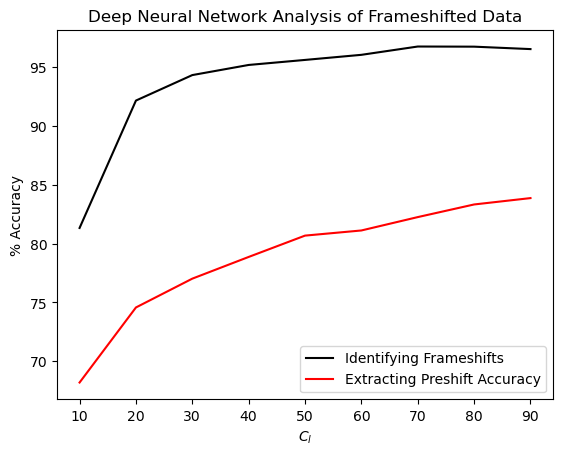

In [24]:
graph(range(10, len(pred1)*10+10, 10), pred1, pred2)

In [30]:
# In between prediction (integrated network)
test = []
pred1 = []
pred3 = []
for i in range(10, 100, 10):
    for i in range(10):
        test.append(0)
    
    #pred1.append(detectFrameshift(test)[1])
    
    input_list = test

    q = len(input_list)

    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(q,)),
        tf.keras.layers.Dense(q / 2, activation='relu'),
        tf.keras.layers.Dense(q / 2, activation='relu'),
        tf.keras.layers.Dense(q / 2, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='sgd',
        loss='mae',
        metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])

    samples = q * 50
    shiftProb = 0.80


    ansInputs = []
    ansOutputs = []
    ansProbs = []

    for n in range(samples):
        for i in range(int(100/options),95,5):
            normal_accuracy = i/100
            key = generateKey(q)
            ansL = generateAnsList(key, generateAns(key))
            ansInputs.append(ansL)
            ansOutputs.append(normal_accuracy)
            ansL = generateAnsList(key, frameShift(generateAns(key), shiftProb))
            ansInputs.append(ansL)
            ansOutputs.append(normal_accuracy)
            ansProbs.append(calcAcc(key, ansL))

    samples = len(ansInputs)

    ansInputTrain = ansInputs[:int(samples*.8)]
    ansOutputTrain = ansOutputs[:int(samples*.8)]


    ansInputTest = ansInputs[int(samples*.8):]
    ansOutputTest = ansOutputs[int(samples*.8):]

    #print(len(ansInputTest))

    model.fit(ansInputTrain, ansOutputTrain, epochs=25)

    print(model.evaluate(ansInputTrain, ansOutputTrain))
    x = model.evaluate(ansInputTest, ansOutputTest)
    
    pred3.append(100 - x[1])   
    

Epoch 1/25
350/350 [==============================] - 2s 4ms/step - loss: 0.1724 - mean_absolute_percentage_error: 37.4414
Epoch 2/25
350/350 [==============================] - 1s 4ms/step - loss: 0.1654 - mean_absolute_percentage_error: 36.3025
Epoch 3/25
350/350 [==============================] - 1s 3ms/step - loss: 0.1598 - mean_absolute_percentage_error: 35.2117
Epoch 4/25
350/350 [==============================] - 1s 4ms/step - loss: 0.1551 - mean_absolute_percentage_error: 33.9369
Epoch 5/25
350/350 [==============================] - 1s 3ms/step - loss: 0.1510 - mean_absolute_percentage_error: 32.9668
Epoch 6/25
350/350 [==============================] - 1s 4ms/step - loss: 0.1474 - mean_absolute_percentage_error: 31.9738
Epoch 7/25
350/350 [==============================] - 1s 4ms/step - loss: 0.1444 - mean_absolute_percentage_error: 31.0912
Epoch 8/25
350/350 [==============================] - 1s 3ms/step - loss: 0.1417 - mean_absolute_percentage_error: 30.2931
Epoch 9/25
350/3

1050/1050 [==============================] - 4s 4ms/step - loss: 0.0980 - mean_absolute_percentage_error: 19.0183
Epoch 13/25
1050/1050 [==============================] - 4s 4ms/step - loss: 0.0979 - mean_absolute_percentage_error: 18.9699
Epoch 14/25
1050/1050 [==============================] - 4s 4ms/step - loss: 0.0978 - mean_absolute_percentage_error: 18.9402
Epoch 15/25
1050/1050 [==============================] - 4s 4ms/step - loss: 0.0977 - mean_absolute_percentage_error: 18.9135
Epoch 16/25
1050/1050 [==============================] - 4s 4ms/step - loss: 0.0977 - mean_absolute_percentage_error: 18.9144
Epoch 17/25
1050/1050 [==============================] - 4s 3ms/step - loss: 0.0976 - mean_absolute_percentage_error: 18.9223
Epoch 18/25
1050/1050 [==============================] - 4s 3ms/step - loss: 0.0976 - mean_absolute_percentage_error: 18.9102
Epoch 19/25
1050/1050 [==============================] - 4s 4ms/step - loss: 0.0975 - mean_absolute_percentage_error: 18.8581
Epoc

1750/1750 [==============================] - 6s 3ms/step - loss: 0.0792 - mean_absolute_percentage_error: 15.4030
Epoch 24/25
1750/1750 [==============================] - 6s 3ms/step - loss: 0.0791 - mean_absolute_percentage_error: 15.3650
Epoch 25/25
1750/1750 [==============================] - 6s 3ms/step - loss: 0.0787 - mean_absolute_percentage_error: 15.5236
[0.07874340564012527, 15.523603439331055]
438/438 [==============================] - 2s 4ms/step - loss: 0.0794 - mean_absolute_percentage_error: 15.7082
Epoch 1/25
2100/2100 [==============================] - 10s 4ms/step - loss: 0.1115 - mean_absolute_percentage_error: 23.8213
Epoch 2/25
2100/2100 [==============================] - 7s 4ms/step - loss: 0.0900 - mean_absolute_percentage_error: 17.4790
Epoch 3/25
2100/2100 [==============================] - 8s 4ms/step - loss: 0.0859 - mean_absolute_percentage_error: 16.5713
Epoch 4/25
2100/2100 [==============================] - 8s 4ms/step - loss: 0.0842 - mean_absolute_perce

2800/2800 [==============================] - 10s 4ms/step - loss: 0.0760 - mean_absolute_percentage_error: 14.5776
Epoch 7/25
2800/2800 [==============================] - 10s 4ms/step - loss: 0.0750 - mean_absolute_percentage_error: 14.4040
Epoch 8/25
2800/2800 [==============================] - 10s 4ms/step - loss: 0.0739 - mean_absolute_percentage_error: 14.1948
Epoch 9/25
2800/2800 [==============================] - 10s 4ms/step - loss: 0.0726 - mean_absolute_percentage_error: 13.9564
Epoch 10/25
2800/2800 [==============================] - 10s 4ms/step - loss: 0.0715 - mean_absolute_percentage_error: 13.7647
Epoch 11/25
2800/2800 [==============================] - 9s 3ms/step - loss: 0.0706 - mean_absolute_percentage_error: 13.6183
Epoch 12/25
2800/2800 [==============================] - 9s 3ms/step - loss: 0.0700 - mean_absolute_percentage_error: 13.5089
Epoch 13/25
2800/2800 [==============================] - 10s 3ms/step - loss: 0.0695 - mean_absolute_percentage_error: 13.4269
E

In [31]:
pred3

[75.12164115905762,
 79.39859008789062,
 81.08611297607422,
 82.7035140991211,
 84.2917947769165,
 85.83714294433594,
 86.12796592712402,
 87.01557636260986,
 87.49264526367188]

In [36]:
import matplotlib.pyplot as plt

def graph(x, y, z, w):
    plt.plot(x, y, label = "Identifying Frameshifts", color='k')        
    plt.plot(x, z, label = "Extracting Preshift Accuracy", color='r')
    plt.plot(x, w, label = "Extracting Generalized Accuracy", color='b')

    
    plt.xlabel('$C_l$') 
    plt.ylabel('% Accuracy')
    plt.title('Deep Neural Network Analysis of Frameshifted Data')
    plt.legend(loc="lower right")
    plt.savefig('graph.pdf')
    plt.show()

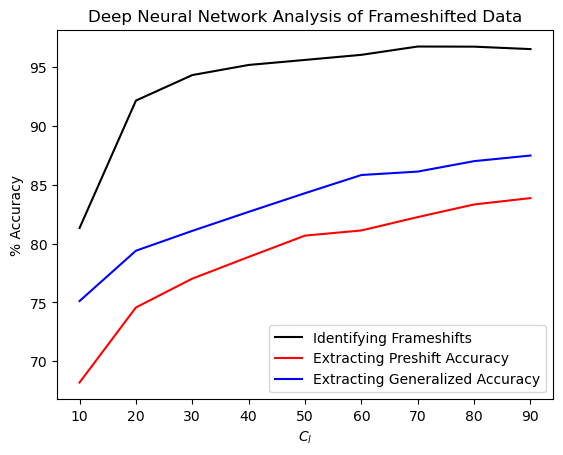

In [37]:
graph(range(10, len(pred1)*10+10, 10), pred1, pred2, pred3)